from https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [8]:
dt = pd.read_csv("datasets/heart-disease-uci/heart.csv")

In [11]:
dt.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [13]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 
              'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels',
              'thalassemia', 'target']

In [14]:
dt.head(10)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [15]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

In [16]:
dt.head(10)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,non-anginal pain,145,233,greater than 120mg/ml,normal,150,no,2.3,0,0,normal,1
1,37,male,atypical angina,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,0,0,fixed defect,1
2,41,female,typical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,flat,0,fixed defect,1
3,56,male,typical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,flat,0,fixed defect,1
4,57,female,0,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,flat,0,fixed defect,1
5,57,male,0,140,192,lower than 120mg/ml,ST-T wave abnormality,148,no,0.4,upsloping,0,normal,1
6,56,female,typical angina,140,294,lower than 120mg/ml,normal,153,no,1.3,upsloping,0,fixed defect,1
7,44,male,typical angina,120,263,lower than 120mg/ml,ST-T wave abnormality,173,no,0.0,flat,0,reversable defect,1
8,52,male,atypical angina,172,199,greater than 120mg/ml,ST-T wave abnormality,162,no,0.5,flat,0,reversable defect,1
9,57,male,atypical angina,150,168,lower than 120mg/ml,ST-T wave abnormality,174,no,1.6,flat,0,fixed defect,1


In [17]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [18]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [19]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [20]:
dt = pd.get_dummies(dt, drop_first=True)

In [21]:
dt.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0


In [23]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10)

In [24]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [28]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [29]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[28,  7],
       [ 3, 23]], dtype=int64)

In [30]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.9032258064516129
Specificity :  0.7666666666666667


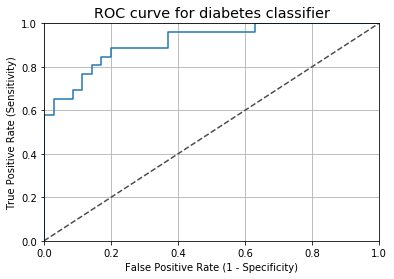

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [32]:
auc(fpr, tpr)

0.9131868131868132

In [33]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0754 ± 0.0445,thalassemia_reversable defect
0.0459 ± 0.0321,max_heart_rate_achieved
0.0393 ± 0.0334,num_major_vessels
0.0295 ± 0.0245,st_depression
0.0197 ± 0.0382,thalassemia_fixed defect
0.0197 ± 0.0245,rest_ecg_normal
0.0164 ± 0.0000,exercise_induced_angina_yes
0.0131 ± 0.0131,sex_male
0.0131 ± 0.0131,cholesterol
0.0066 ± 0.0334,age


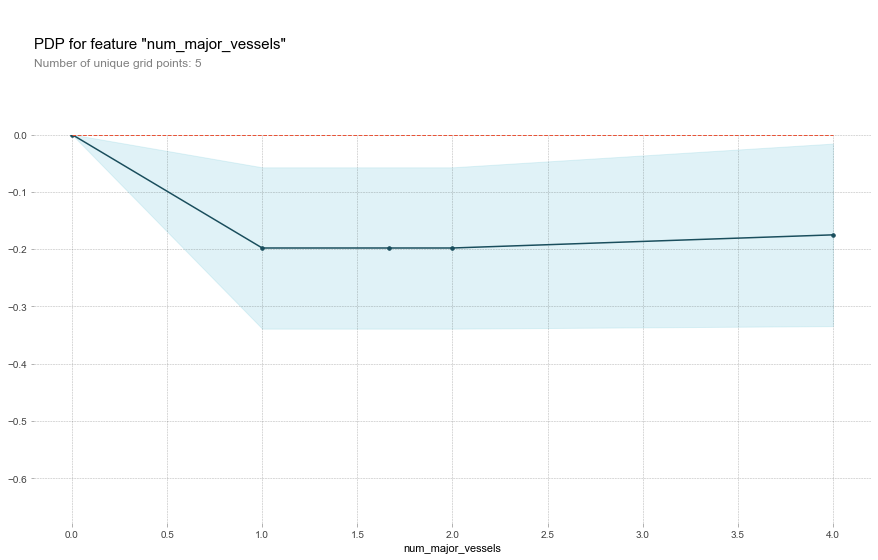

In [34]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

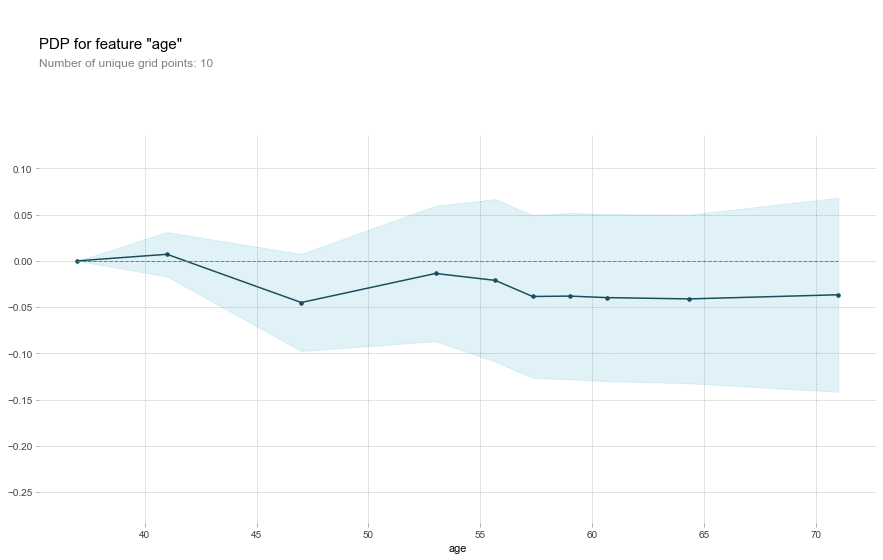

In [35]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

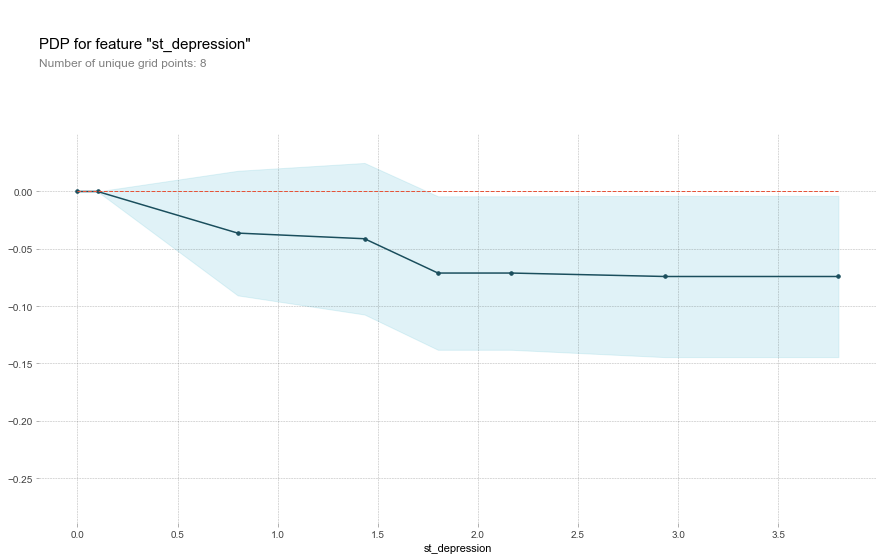

In [37]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

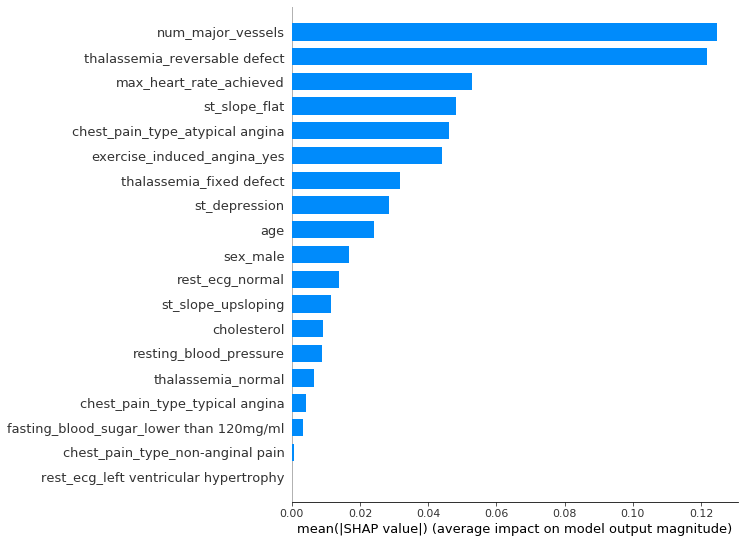

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

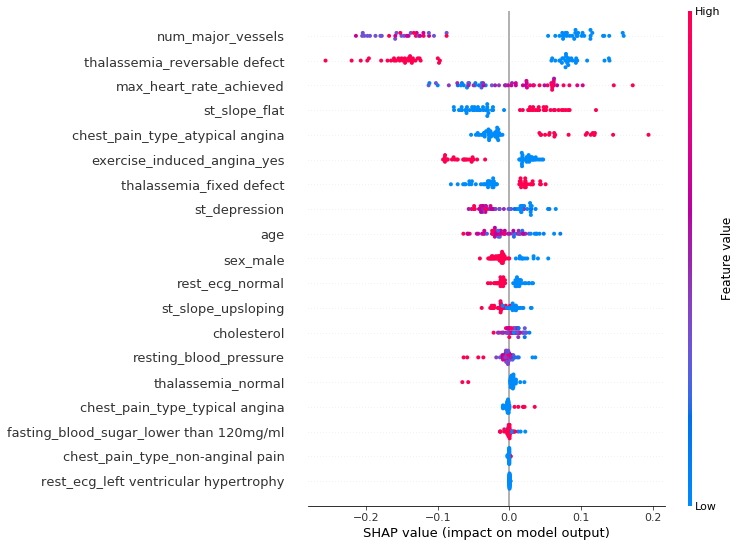

In [40]:
shap.summary_plot(shap_values[1], X_test)

In [41]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [42]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

In [43]:
data_for_prediction = X_test.iloc[3,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

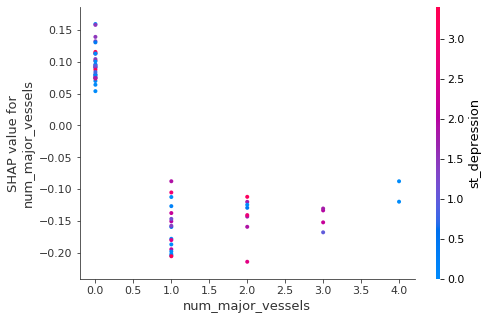

In [44]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('num_major_vessels', shap_values[1], X_test, interaction_index="st_depression")

In [45]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])